<a href="https://colab.research.google.com/github/jeffveleze/age-calculator/blob/master/AgeCalculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow==2.0

### Importing Libraries

In [0]:
# Helper libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import PIL
import pickle

from PIL import Image
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, MaxPool2D, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Reading Data

In [103]:
# Define folder paths
folder_base_dir = '/content/drive/My Drive/Age-Gender-Recognizer-Dataset/'

# Create local folder data path 
folder_data_path = folder_base_dir + '**'
folder_data_path = os.path.expanduser(folder_data_path)

# Create array with folder image addresses
folder_addresses = glob.glob(folder_data_path)

# Initialize image_addresses empty list
image_addresses = []

print("Started looping folders")

# Used to count loaded folders
current_folders_loaded = 0
max_folders_loaded = 5

# Loop all the folders to get the addresses
for folder_address in folder_addresses:
  files_extension = '.jpg'

  # Create folder address path object
  folder_address_path = folder_address + '/*' + files_extension
  folder_address_path = os.path.expanduser(folder_address_path)

  # Create array with image addresses
  image_addresses_per_folder = glob.glob(folder_address_path)
  image_addresses += image_addresses_per_folder

  # Control the number of folders loadead
  current_folders_loaded += 1
  if current_folders_loaded == max_folders_loaded:
    break

print("Finished looping folders")

# Create function to extract data
def make_address_data(address):
  name_components = address.split('_')
  image_id = name_components[0].split('/')
  image_id = image_id[-1]
  birth_date = name_components[1]
  publish_date = name_components[2].replace(files_extension, '')
  birth_date_year = int(birth_date.split('-')[0])

  # Add a try-except when casting the publish_date
  try:
      publish_date_year = int(publish_date)
  except ValueError:
      # Handle the exception
      return (-1, -1, -1, -1, -1)

  age = publish_date_year - birth_date_year

  return (image_id, birth_date, birth_date_year, publish_date_year, age)

# Create initial values
RESIZED_WIDTH = 224
RESIZED_HEIGHT = 224
addresses = []
image_ids = []
birth_dates = []
birth_date_years = []
publish_date_years = []
ages = []
data_extraction_fails = 0

print("Started filling lists")

for address in image_addresses:
  image_id, birth_date, birth_date_year, publish_date_year, age = make_address_data(address)

  # Count filtered images bcz of wrong name
  if image_id == -1 and birth_date == -1:
    data_extraction_fails += 1

  if age > 0 and age < 100:

    # Appending path taken values
    addresses.append(address)
    image_ids.append(image_id)
    birth_dates.append(birth_date)
    birth_date_years.append(birth_date_year)
    publish_date_years.append(publish_date_year)
    ages.append(age)

print("Finished filling lists")
print("Files with wrong names:", data_extraction_fails)

np.array(ages).shape

Started looping folders
Finished looping folders
Started filling lists
Finished filling lists
Files with wrong names: 0


(2986,)

### Exploring Data

In [106]:
# Create dictionary arrays
images_dictionary = {'image_address': addresses, 'age' : ages}
images_data_frame = pd.DataFrame(images_dictionary)

# Visualize dataframe
images_data_frame.head()

,image_address,age
0,/content/drive/My Drive/Age-Gender-Recognizer-...,48
1,/content/drive/My Drive/Age-Gender-Recognizer-...,24
2,/content/drive/My Drive/Age-Gender-Recognizer-...,56
3,/content/drive/My Drive/Age-Gender-Recognizer-...,32
4,/content/drive/My Drive/Age-Gender-Recognizer-...,24


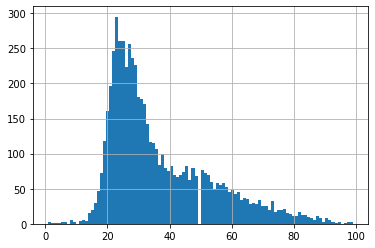

In [105]:
images_data_frame['age'].hist(bins = 100)            

In [94]:
images_data_frame.describe()

,age
count,5996.000000
mean,36.976818
std,16.594199
min,1.000000
25%,25.000000
50%,31.000000
75%,47.000000
max,99.000000


### Splitting Data

In [107]:
# Separating X and Y columns
X_df = images_data_frame['image_address'].copy()
Y_df = images_data_frame['age'].copy()

# Splitting train and test data
train_image_addresses, test_image_addresses, train_labels, test_labels = train_test_split(X_df, 
                                                                                          Y_df, 
                                                                                          test_size = 0.1, 
                                                                                          random_state = 2)

# Creating train and test dataframes
train_dictionary = {'train_image_addresses': train_image_addresses, 'train_labels' : train_labels}
test_dictionary = {'test_image_addresses': test_image_addresses, 'test_labels' : test_labels}
train_df = pd.DataFrame(train_dictionary)
test_df = pd.DataFrame(test_dictionary)

# Verifying correct shape
print(train_df.shape)
print(test_df.shape)

(2687, 2)
(299, 2)


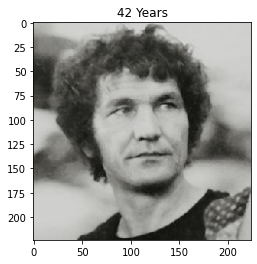

In [108]:
# Define random number to display image
image_index = 200

# Transforming images into matrixes and applying resizing
train_image_addresses_list = train_image_addresses.tolist()
train_labels_list = train_labels.tolist()
image = Image.open(train_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(train_labels_list[image_index]) + " Years")
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### Defining Hyperparameters

In [0]:
# Defining hyperparameters
hyperparams = {'dense' : 4, 
               'units': 256, 
               'activation' : 'relu', 
               'dropout': 0.15}

# Defining epochs and batch_size
batch_size = 32
epochs = 10           

### Creating Generators

In [0]:
validation_split = 0.1

# Generators for our data
train_image_generator = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = validation_split
)

test_image_generator = ImageDataGenerator(rescale = 1./255)

In [111]:
# Load images from the disk, applies rescaling and resizes for train, validation and test
train_data_gen = train_image_generator.flow_from_dataframe(dataframe = train_df,
                                                           x_col = 'train_image_addresses',
                                                           y_col = 'train_labels',
                                                           batch_size = batch_size,
                                                           shuffle = False,
                                                           target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                           class_mode = 'raw',
                                                           subset = 'training')

validation_data_gen = train_image_generator.flow_from_dataframe(dataframe = train_df,
                                                           x_col = 'train_image_addresses',
                                                           y_col = 'train_labels',
                                                           batch_size = batch_size,
                                                           shuffle = False,
                                                           target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                           class_mode = 'raw',
                                                           subset = 'validation')

test_data_gen = test_image_generator.flow_from_dataframe(dataframe = test_df,
                                                         x_col = 'test_image_addresses',
                                                         y_col = 'test_labels',
                                                         batch_size = batch_size,
                                                         shuffle = False,
                                                         target_size = (RESIZED_WIDTH, RESIZED_HEIGHT),
                                                         class_mode = 'raw')

train_df_size = train_df.shape[0]

Found 2419 validated image filenames.
Found 268 validated image filenames.
Found 299 validated image filenames.


### Fully Connected Functional Model

In [0]:
# Load the model
functional_model = keras.models.load_model("functional_model.h5")

# # Load the history
with open('fm.serialized','rb') as file_object:
    fmh_raw_data = file_object.read()

fmh_dict = pickle.loads(fmh_raw_data)

functional_model.summary()

In [0]:
# Adding function to create functional model
def make_functional_model(hyperparams):

  inputs = tf.keras.Input(shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3))
  x1 = tf.keras.layers.Flatten()(inputs)
  x = x1

  units = hyperparams['units']
  
  # Inserting new layers 
  while units >= 8:
    x = tf.keras.layers.Dense(units, activation = hyperparams['activation'])(x)
    x = tf.keras.layers.Dropout(hyperparams['dropout'])(x)
    units /= 2

  x2 = tf.keras.layers.Dense(32)(x1)
  x = tf.keras.layers.Concatenate()([x, x2])
  outputs = tf.keras.layers.Dense(1)(x)

  functional_model = tf.keras.Model(inputs = inputs, outputs = outputs)
  
  return functional_model

In [0]:
# Creating model
functional_model = make_functional_model(hyperparams)

# Compiling models
functional_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

functional_model.summary()

In [62]:
# Training the model
fm_history = functional_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

fmh_dict = fm_history.history

Epoch 1/10
16/16 [==============================] - 7s 414ms/step - loss: 33769.1011 - mae: 143.3315 - val_loss: 20584.0371 - val_mae: 130.1993
Epoch 2/10
16/16 [==============================] - 6s 364ms/step - loss: 6211.0619 - mae: 61.6707 - val_loss: 2938.1536 - val_mae: 48.9367
Epoch 3/10
16/16 [==============================] - 6s 377ms/step - loss: 2196.5410 - mae: 38.1791 - val_loss: 1048.3037 - val_mae: 25.9888
Epoch 4/10
16/16 [==============================] - 6s 363ms/step - loss: 795.7161 - mae: 23.2201 - val_loss: 660.9527 - val_mae: 21.4194
Epoch 5/10
16/16 [==============================] - 6s 370ms/step - loss: 533.7036 - mae: 18.1862 - val_loss: 749.1525 - val_mae: 20.9613
Epoch 6/10
16/16 [==============================] - 6s 384ms/step - loss: 467.3365 - mae: 17.0280 - val_loss: 706.8195 - val_mae: 22.4406
Epoch 7/10
16/16 [==============================] - 6s 376ms/step - loss: 481.5383 - mae: 17.5080 - val_loss: 682.8047 - val_mae: 21.8927
Epoch 8/10
16/16 [======

In [0]:
# Save the Model
functional_model.save("functional_model.h5")

# Save the history
fmh_serialized = pickle.dumps(fm_history.history)

with open('fm.serialized', 'wb') as file_object:
    file_object.write(fmh_serialized)

In [64]:
# Print resulting functional_model metrics for train
train_mse_fm, train_mae_fm = functional_model.evaluate_generator(train_data_gen)

print("Train MSE Functional Model: {}".format(train_mse_fm))
print("Train MAE Functional Model: {}".format(train_mae_fm))

Train MSE Functional Model: 370.39100952148436
Train MAE Functional Model: 14.996393203735352


In [65]:
# Print resulting functional_model metrics for test
test_mse_fm, test_mae_fm = functional_model.evaluate_generator(test_data_gen)

print("Test MSE Functional Model: {}".format(test_mse_fm))
print("Test MAE Functional Model: {}".format(test_mae_fm))

Test MSE Functional Model: 537.462890625
Test MAE Functional Model: 15.491336822509766


In [66]:
# Predicting with test data
predicted_labels_fm = functional_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_fm = mean_squared_error(test_labels, predicted_labels_fm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_fm))

test_mae_fm = mean_absolute_error(test_labels, predicted_labels_fm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_fm))

test_r2_fm = r2_score(test_labels, predicted_labels_fm)
print("R_2 = {:.3f}".format(test_r2_fm))

Mean Square Error (MSE)= 526.46
Mean Absolute Error (MAE)= 15.49
R_2 = -0.945


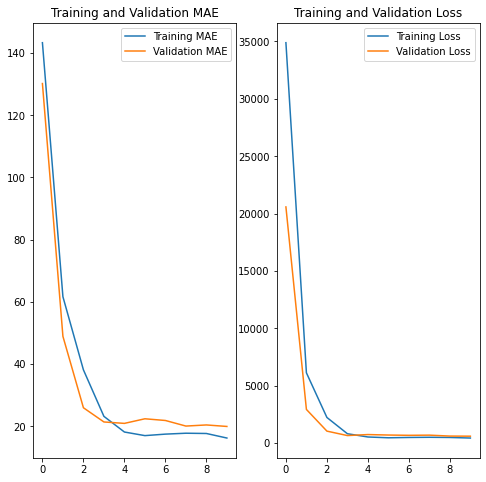

In [67]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = fmh_dict['mae']
val_mae = fmh_dict['val_mae']

loss = fmh_dict['loss']
val_loss = fmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

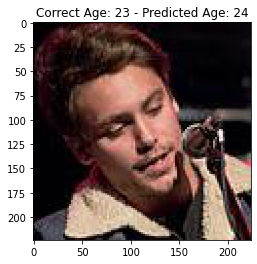

In [68]:
# Visualizing model predictions

# Define random number to display image
image_index = 20

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_fm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### Fully Connected Sequential Model

In [0]:
# Load the model
sequential_model = keras.models.load_model("sequential_model.h5")

# # Load the history
with open('sm.serialized','rb') as file_object:
    smh_raw_data = file_object.read()

smh_dict = pickle.loads(smh_raw_data)

sequential_model.summary()

In [0]:
# Adding function to create sequential model
def make_sequential_model(hyperparams):

  layers_list = []
  layers_list.append(
      tf.keras.layers.Flatten(input_shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3))
  )

  units = hyperparams['units']
  
  # Inserting new layers 
  while units >= 8:
    layers_list.append(tf.keras.layers.Dense(units, activation = hyperparams['activation']))
    layers_list.append(tf.keras.layers.Dropout(hyperparams['dropout']))
    units /= 2

  # No activation function is used for the output layer because it's a 
  # regression problem and we are interested in predicting numerical values 
  # directly without transform.
  layers_list.append(tf.keras.layers.Dense(1))
  sequential_model = tf.keras.models.Sequential(layers_list)

  return sequential_model

In [0]:
# Creating model
sequential_model = make_sequential_model(hyperparams)

# Compiling model
sequential_model.compile(optimizer = 'adam',
                         loss = 'mse',
                         metrics = ['mae'])

sequential_model.summary()

In [0]:
# Training the model
sm_history = sequential_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

smh_dict = sm_history.history

In [0]:
# Save the Model
sequential_model.save("sequential_model.h5")

# Save the history
smh_serialized = pickle.dumps(sm_history.history)

with open('sm.serialized', 'wb') as file_object:
    file_object.write(smh_serialized)

In [74]:
# Print resulting sequential_model metrics for train
train_mse_sm, train_mae_sm = sequential_model.evaluate_generator(train_data_gen)

print("Train MSE Sequential Model: {}".format(train_mse_sm))
print("Train MAE Sequential Model: {}".format(train_mae_sm))

Train MSE Sequential Model: 649.6671447753906
Train MAE Sequential Model: 19.993732452392578


In [75]:
# Print resulting sequential_model metrics for test
test_mse_sm, test_mae_sm = sequential_model.evaluate_generator(test_data_gen)

print("Test MSE Sequential Model: {}".format(test_mse_sm))
print("Test MAE Sequential Model: {}".format(test_mae_sm))

Test MSE Sequential Model: 808.5697326660156
Test MAE Sequential Model: 21.70051383972168


In [76]:
# Predicting with test data
predicted_labels_sm = sequential_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_sm = mean_squared_error(test_labels, predicted_labels_sm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_sm))

test_mae_sm = mean_absolute_error(test_labels, predicted_labels_sm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_sm))

test_r2_sm = r2_score(test_labels, predicted_labels_sm)
print("R_2 = {:.3f}".format(test_r2_sm))

Mean Square Error (MSE)= 788.46
Mean Absolute Error (MAE)= 21.70
R_2 = -1.912


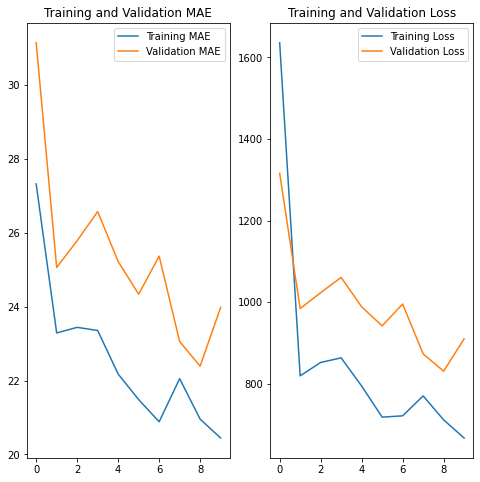

In [77]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = smh_dict['mae']
val_mae = smh_dict['val_mae']

loss = smh_dict['loss']
val_loss = smh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

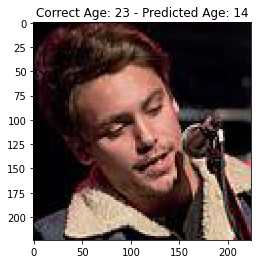

In [78]:
# Visualizing model predictions

# Define random number to display image
image_index = 20

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_sm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

###CNN Model

In [0]:
# Load the model
cnn_model = keras.models.load_model("cnn_model.h5")

# # Load the history
with open('cnnm.serialized','rb') as file_object:
    cnnmh_raw_data = file_object.read()

cnnmh_dict = pickle.loads(cnnmh_raw_data)

cnn_model.summary()

In [0]:
# Define function to create CNN

def create_cnn(width, height, depth, filters = (16, 32, 64)):
	inputShape = (height, width, depth)
	chanDim = -1

	# Define the model input
	inputs = Input(shape = inputShape)

	# Loop over the number of filters
	for (i, f) in enumerate(filters):
	
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding = "same")(x)
		x = BatchNormalization(axis = chanDim)(x)
		x = Activation("relu")(x)
		x = MaxPooling2D(pool_size = (2, 2))(x)
		x = Dropout(0.15)(x)
	
	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(512)(x)
	x = BatchNormalization(axis = chanDim)(x)
	x = Activation("relu")(x)
	# x = Dropout(0.15)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(16)(x)
	x = Activation("relu")(x)

	x = Dense(1, activation = "linear")(x)
	
	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

  # model = Sequential([
  #   Conv2D(16, 3, padding='same', activation='relu', input_shape=(width, height, 3)),
  #   MaxPooling2D(),
  #   Conv2D(32, 3, padding='same', activation='relu'),
  #   MaxPooling2D(),
  #   Conv2D(64, 3, padding='same', activation='relu'),
  #   MaxPooling2D(),
  #   Flatten(),
  #   # Dense(512, activation='relu'),
  #   Dense(512),
  #   Dense(1)
  # ])

  # return model

In [0]:
# Creating CNN
cnn_model = create_cnn(RESIZED_WIDTH, RESIZED_HEIGHT, 3)

# Compile model
cnn_model.compile(optimizer = 'adam',
                  loss = 'mse',
                  metrics = ['mae'])

cnn_model.summary()

In [82]:
# Training the model
cnnm_history = cnn_model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_df_size // batch_size,
    validation_data = validation_data_gen,
    validation_steps = train_df_size // batch_size,
    epochs = epochs
)

cnnmh_dict = cnnm_history.history

Epoch 1/10
16/16 [==============================] - 37s 2s/step - loss: 1413.8632 - mae: 33.9745 - val_loss: 1587.5016 - val_mae: 35.5803
Epoch 2/10
16/16 [==============================] - 35s 2s/step - loss: 1070.1800 - mae: 29.0776 - val_loss: 1212.3766 - val_mae: 29.9016
Epoch 3/10
16/16 [==============================] - 36s 2s/step - loss: 765.0113 - mae: 23.4767 - val_loss: 829.8205 - val_mae: 22.7381
Epoch 4/10
16/16 [==============================] - 37s 2s/step - loss: 517.7695 - mae: 18.7374 - val_loss: 495.1926 - val_mae: 15.7310
Epoch 5/10
16/16 [==============================] - 36s 2s/step - loss: 236.6727 - mae: 11.9634 - val_loss: 315.6174 - val_mae: 13.2572
Epoch 6/10
16/16 [==============================] - 36s 2s/step - loss: 132.6920 - mae: 8.7274 - val_loss: 307.2889 - val_mae: 14.2302
Epoch 7/10
16/16 [==============================] - 35s 2s/step - loss: 82.1228 - mae: 6.3714 - val_loss: 334.0333 - val_mae: 15.8733
Epoch 8/10
16/16 [=============================

In [0]:
# Save the Model
cnn_model.save("cnn_model.h5")

# Save the history
cnnmh_serialized = pickle.dumps(cnnm_history.history)

with open('cnnm.serialized', 'wb') as file_object:
    file_object.write(cnnmh_serialized)

In [84]:
# Print resulting cnn_model metrics for train
train_mse_cnnm, train_mae_cnnm = cnn_model.evaluate_generator(train_data_gen)

print("Train MSE CNN Model: {}".format(train_mse_cnnm))
print("Train MAE CNN Model: {}".format(train_mae_cnnm))

Train MSE CNN Model: 353.9519785563151
Train MAE CNN Model: 16.41362190246582


In [85]:
# Print resulting cnn_model metrics for test
test_mse_cnnm, test_mae_cnnm = cnn_model.evaluate_generator(test_data_gen)

print("Test MSE CNN Model: {}".format(test_mse_cnnm))
print("Test MAE CNN Model: {}".format(test_mae_cnnm))

Test MSE CNN Model: 374.5807647705078
Test MAE CNN Model: 16.195478439331055


In [86]:
# Predicting with test data
predicted_labels_cnnm = cnn_model.predict_generator(test_data_gen)

# Calculating some more metrics
test_mse_cnnm = mean_squared_error(test_labels, predicted_labels_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_cnnm))

test_mae_cnnm = mean_absolute_error(test_labels, predicted_labels_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_cnnm))

test_r2_cnnm = r2_score(test_labels, predicted_labels_cnnm)
print("R_2 = {:.3f}".format(test_r2_cnnm))

Mean Square Error (MSE)= 375.74
Mean Absolute Error (MAE)= 16.20
R_2 = -0.388


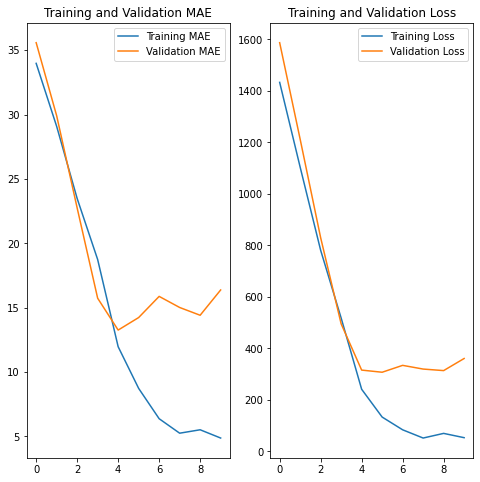

In [87]:
# Visualizing MAE and Loss for Training and Validation Sets
mae = cnnmh_dict['mae']
val_mae = cnnmh_dict['val_mae']

loss = cnnmh_dict['loss']
val_loss = cnnmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, mae, label = 'Training MAE')
plt.plot(epochs_range, val_mae, label = 'Validation MAE')
plt.legend(loc = 'upper right')
plt.title('Training and Validation MAE')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

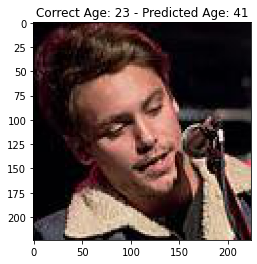

In [88]:
# Visualizing model predictions

# Define random number to display image
image_index = 20

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()
predicted_test_labels_list = predicted_labels_cnnm.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_test_labels_list[image_index][0]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### CNN Model VGG-16 Architecture

In [0]:
def make_VGG16_cnn_model(hyperparams):
  model = Sequential()
  
  model.add(Conv2D(input_shape=(RESIZED_WIDTH,RESIZED_HEIGHT,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=101, activation="softmax"))

  return model

In [118]:
# Creating model
vgg16_cnn_model = make_VGG16_cnn_model(hyperparams)

# Compiling model
vgg16_cnn_model.compile(optimizer = 'adam', 
                        loss = 'sparse_categorical_crossentropy', 
                        metrics = ['accuracy'])

vgg16_cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 56, 56, 256)      

In [0]:
# Training the model
vgg16_cnnm_history = vgg16_cnn_model.fit_generator(steps_per_epoch = train_df_size // batch_size,
                                                   generator = train_data_gen, 
                                                   validation_data = validation_data_gen, 
                                                   validation_steps = train_df_size // batch_size, 
                                                   epochs = epochs)

vgg16_cnnmh_dict = vgg16_cnnm_history.history

Epoch 1/10
84/84 [==============================] - 7106s 85s/step - loss: 4.1206 - accuracy: 0.0405 - val_loss: 4.0302 - val_accuracy: 0.0307
Epoch 2/10
84/84 [==============================] - 6742s 80s/step - loss: 4.0156 - accuracy: 0.0416 - val_loss: 4.0195 - val_accuracy: 0.0307
Epoch 3/10
83/84 [============================>.] - ETA: 1:01 - loss: 4.0178 - accuracy: 0.0433

In [0]:
# Save the Model
vgg16_cnn_model.save("vgg16_cnn_model.h5")

# Save the history
vgg16_cnnmh_serialized = pickle.dumps(vgg16_cnnm_history.history)

with open('vgg16_cnnm.serialized', 'wb') as file_object:
    file_object.write(cnnmh_serialized)

In [51]:
# Print resulting cnn_model metrics for train
train_scce_vgg16_cnnm, train_accuracy_vgg16_cnnm = vgg16_cnn_model.evaluate_generator(train_data_gen)

print("Train Sparse Categorical Cross Entropy VGG16 CNN Model: {}".format(train_scce_vgg16_cnnm))
print("Train Accuracy VGG16 CNN Model: {}".format(train_accuracy_vgg16_cnnm))

Train Sparse Categorical Cross Entropy VGG16 CNN Model: 3.88238787651062
Train Accuracy VGG16 CNN Model: 0.057208236306905746


In [52]:
# Print resulting cnn_model metrics for test
test_scce_vgg16_cnnm, test_accuracy_vgg16_cnnm = vgg16_cnn_model.evaluate_generator(test_data_gen)

print("Train Sparse Categorical Cross Entropy VGG16 CNN Model: {}".format(test_scce_vgg16_cnnm))
print("Train Accuracy VGG16 CNN Model: {}".format(test_accuracy_vgg16_cnnm))

Train Sparse Categorical Cross Entropy VGG16 CNN Model: 4.239378929138184
Train Accuracy VGG16 CNN Model: 0.0517241396009922


In [0]:
# Predicting with test data
predicted_probability_labels_vgg16_cnnm = vgg16_cnn_model.predict_generator(test_data_gen)

In [97]:
# Calculating max probability items in predicted probability items list
predicted_labels_vgg16_cnnm = []

for prediction_for_image in predicted_probability_labels_vgg16_cnnm:
  max_probability_predicted_value = np.argmax(prediction_for_image)
  predicted_labels_vgg16_cnnm.append(max_probability_predicted_value)

# Calculating some more metrics
test_mse_vgg16_cnnm = mean_squared_error(test_labels, predicted_labels_vgg16_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_vgg16_cnnm))

test_mae_vgg16_cnnm = mean_absolute_error(test_labels, predicted_labels_vgg16_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_vgg16_cnnm))

test_r2_vgg16_cnnm = r2_score(test_labels, predicted_labels_vgg16_cnnm)
print("R_2 = {:.3f}".format(test_r2_vgg16_cnnm))

Mean Square Error (MSE)= 517.97
Mean Absolute Error (MAE)= 16.41
R_2 = -0.913


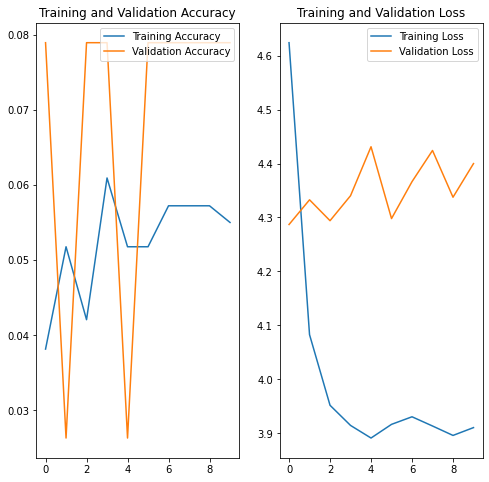

In [98]:
# Visualizing Sparse Categorical Cross Entropy Loss and Accuracy for Training and Validation Sets
accuracy = vgg16_cnnmh_dict['accuracy']
val_accuracy = vgg16_cnnmh_dict['val_accuracy']

loss = vgg16_cnnmh_dict['loss']
val_loss = vgg16_cnnmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

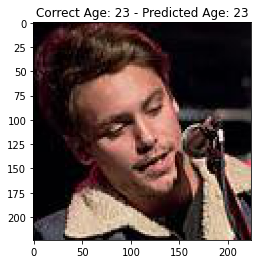

In [100]:
# Visualizing model predictions

# Define random number to display image
image_index = 20

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_labels_vgg16_cnnm[image_index]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()

### CNN Model Pre-Trained VGG-16

In [0]:
# def build_model(input_shape, num_genres, freezed_layers = 5):
#     input_tensor = Input(shape=input_shape)
#     vgg16 = VGG16(include_top=False, weights='imagenet',
#                   input_tensor=input_tensor)

#     top = Sequential()
#     top.add(Flatten(input_shape=vgg16.output_shape[1:]))
#     top.add(Dense(256, activation='relu'))
#     top.add(Dropout(0.5))
#     top.add(Dense(num_genres, activation='softmax'))

#     model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
#     for layer in model.layers[:freezed_layers]:
#         layer.trainable = False

#     return model 

# def get_model(num_class, input_size, feature_layer):
#     base_model = VGG16(weights='imagenet', include_top=False,
#                        input_shape=[input_size,input_size,3], classes=num_class)
#     x = base_model.get_layer(feature_layer).output
#     x = GlobalAveragePooling2D()(x)

#     model = Model(inputs=base_model.input, outputs=x)
#     optimizer = Adam(lr=0.0001)
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=optimizer,
#                   metrics=['accuracy'])
#     return model 

In [0]:
def make_VGG16_cnn_pretrained_model(hyperparams):
  # Defining shape
  input_shape = (RESIZED_WIDTH, RESIZED_HEIGHT, 3)

  # Creating base model without top layers
  base_model = tf.keras.applications.VGG16(
      input_shape = input_shape,
      include_top = False,
      weights = 'imagenet'
  )

  # Avoid existent layers weights to be recalculated 
  base_model.trainable = False

  # Create top layers
  number_of_classes = 101
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(number_of_classes, activation = 'softmax')

  # Create final model
  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
  ])

  return model

In [113]:
# Creating model
pretrained_vgg16_cnn_model = make_VGG16_cnn_pretrained_model(hyperparams)

# Compiling model
pretrained_vgg16_cnn_model.compile(optimizer = 'adam', 
                                  loss = 'sparse_categorical_crossentropy', 
                                  metrics = ['accuracy'])

pretrained_vgg16_cnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 101)               51813     
Total params: 14,766,501
Trainable params: 51,813
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# Training the model
pretrained_vgg16_cnnm_history = pretrained_vgg16_cnn_model.fit_generator(
    steps_per_epoch = train_df_size // batch_size,
    generator = train_data_gen, 
    validation_data = validation_data_gen, 
    validation_steps = train_df_size // batch_size, 
    epochs = epochs
)

pretrained_vgg16_cnnmh_dict = pretrained_vgg16_cnnm_history.history

Epoch 1/10
83/83 [==============================] - 3999s 48s/step - loss: 4.1769 - accuracy: 0.0371 - val_loss: 4.0661 - val_accuracy: 0.0513
Epoch 2/10
83/83 [==============================] - 3991s 48s/step - loss: 3.9705 - accuracy: 0.0499 - val_loss: 4.0450 - val_accuracy: 0.0513
Epoch 3/10
83/83 [==============================] - 3992s 48s/step - loss: 3.9283 - accuracy: 0.0556 - val_loss: 4.0275 - val_accuracy: 0.0553
Epoch 4/10
83/83 [==============================] - 3789s 46s/step - loss: 3.8986 - accuracy: 0.0586 - val_loss: 4.0507 - val_accuracy: 0.0590
Epoch 5/10
83/83 [==============================] - 3692s 44s/step - loss: 3.8501 - accuracy: 0.0594 - val_loss: 4.0456 - val_accuracy: 0.0513
Epoch 6/10
83/83 [==============================] - 3663s 44s/step - loss: 3.8511 - accuracy: 0.0640 - val_loss: 4.0371 - val_accuracy: 0.0509
Epoch 7/10
83/83 [==============================] - 3640s 44s/step - loss: 3.7819 - accuracy: 0.0795 - val_loss: 4.0359 - val_accuracy: 0.0630

In [0]:
# Save the Model
pretrained_vgg16_cnn_model.save("pretrained_vgg16_cnn_model.h5")

# Save the history
pretrained_vgg16_cnnmh_serialized = pickle.dumps(pretrained_vgg16_cnnm_history.history)

with open('pretrained_vgg16_cnnm.serialized', 'wb') as file_object:
    file_object.write(cnnmh_serialized)

In [0]:
# Print resulting cnn_model metrics for train
train_scce_pretrained_vgg16_cnnm, train_accuracy_pretrained_vgg16_cnnm = pretrained_vgg16_cnn_model.evaluate_generator(train_data_gen)

print("Train Sparse Categorical Cross Entropy Pretrained VGG16 CNN Model: {}".format(train_scce_pretrained_vgg16_cnnm))
print("Train Accuracy Pretrained VGG16 CNN Model: {}".format(train_accuracy_pretrained_vgg16_cnnm))

In [0]:
# Print resulting cnn_model metrics for test
test_scce_pretrained_vgg16_cnnm, test_accuracy_pretrained_vgg16_cnnm = pretrained_vgg16_cnn_model.evaluate_generator(test_data_gen)

print("Test Sparse Categorical Cross Entropy Pretrained VGG16 CNN Model: {}".format(test_scce_pretrained_vgg16_cnnm))
print("Test Accuracy Pretrained VGG16 CNN Model: {}".format(test_accuracy_pretrained_vgg16_cnnm))

In [0]:
# Predicting with test data
predicted_probability_labels_pretrained_vgg16_cnnm = pretrained_vgg16_cnn_model.predict_generator(test_data_gen)

In [0]:
# Calculating max probability items in predicted probability items list
predicted_labels_pretrained_vgg16_cnnm = []

for prediction_for_image in predicted_probability_labels_pretrained_vgg16_cnnm:
  max_probability_predicted_value = np.argmax(prediction_for_image)
  predicted_labels_pretrained_vgg16_cnnm.append(max_probability_predicted_value)

# Calculating some more metrics
test_mse_pretrained_vgg16_cnnm = mean_squared_error(test_labels, predicted_labels_pretrained_vgg16_cnnm)
print("Mean Square Error (MSE)= {:.2f}".format(test_mse_pretrained_vgg16_cnnm))

test_mae_pretrained_vgg16_cnnm = mean_absolute_error(test_labels, predicted_labels_pretrained_vgg16_cnnm)
print("Mean Absolute Error (MAE)= {:.2f}".format(test_mae_pretrained_vgg16_cnnm))

test_r2_pretrained_vgg16_cnnm = r2_score(test_labels, predicted_labels_pretrained_vgg16_cnnm)
print("R_2 = {:.3f}".format(test_r2_pretrained_vgg16_cnnm))

In [0]:
# Visualizing Sparse Categorical Cross Entropy Loss and Accuracy for Training and Validation Sets
accuracy = pretrained_vgg16_cnnmh_dict['accuracy']
val_accuracy = pretrained_vgg16_cnnmh_dict['val_accuracy']

loss = pretrained_vgg16_cnnmh_dict['loss']
val_loss = pretrained_vgg16_cnnmh_dict['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# Visualizing model predictions

# Define random number to display image
image_index = 20

# Transforming images into matrixes and applying resizing
test_image_addresses_list = test_image_addresses.tolist()
test_labels_list = test_labels.tolist()

correct_age = test_labels_list[image_index]
predicted_age = predicted_labels_pretrained_vgg16_cnnm[image_index]

image = Image.open(test_image_addresses_list[image_index])
image = image.resize((RESIZED_WIDTH, RESIZED_HEIGHT), Image.NEAREST)
image_matrix = np.asarray(image.convert('RGB'))

# Normalizing image_matrix
image_matrix = image_matrix / 255

# Drawing train_images[image_index]
plt.figure()
plt.title(str(test_labels_list[image_index]) + " Years")
title = "Correct Age: " + str(correct_age) + " - Predicted Age: " + str(int(predicted_age))
plt.title(title)
plt.imshow(image, cmap = plt.cm.binary)
plt.grid(False)
plt.show()